In [1]:
!pip install yfinance

In [2]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.7 MB/s eta 0:00:00


In [72]:
#importing the packages
import pandas as pd
import yfinance as yf
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score,confusion_matrix,accuracy_score,classification_report,ConfusionMatrixDisplay,precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt

In [4]:
def get_data(ticker,start_date,end_date):
  '''Gets stock data of ticker from start_date and end_date'''
  df = yf.download(ticker, start=start_date, end=end_date)
  return df



In [5]:
#These functions are related to graphical vizualization of the data
def display_candlestick(df,symbol):
  """
  Displays candlestick chart for the given dataframe
  parameters:
  df: dataframe containing the data
  symbol: symbol of the stock
  """
  mpf.plot(df, type="candle", title=f"Candlestick Chart for {symbol}", ylabel="Price", style="yahoo")
  mpf.show()

def displayMA(df,num_list):
  """
  Displays moving average for the given dataframe
  parameters:
  df: dataframe containing the data
  num_list: list of numbers for moving averages
  """
  for num in num_list:
    df[f"MA{num}"] = df["Close"].rolling(window=num).mean()

  plt.figure(figsize=(12,8))
  plt.plot(df.index,df.Close,label="Close")
  for num in num_list:
    plt.plot(df.index,df[f"MA{num}"],label=f"MA{num}")
  plt.title("Closing Prices with Moving Average")
  plt.xlabel("Date")
  plt.ylabel('Price')
  plt.legend()
  plt.grid(True)
  plt.show()

[*********************100%***********************]  1 of 1 completed


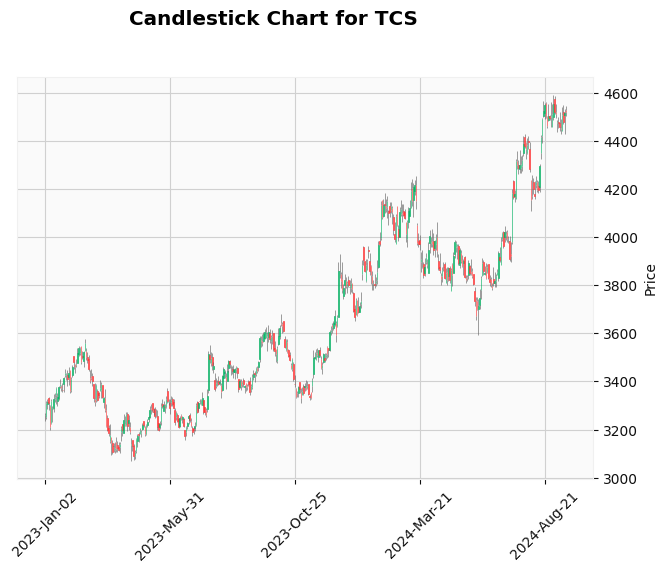

In [49]:
# We are using TCS stock data for this
data=get_data('TCS.NS','2023-01-01','2024-09-14')
display_candlestick(data,'TCS')

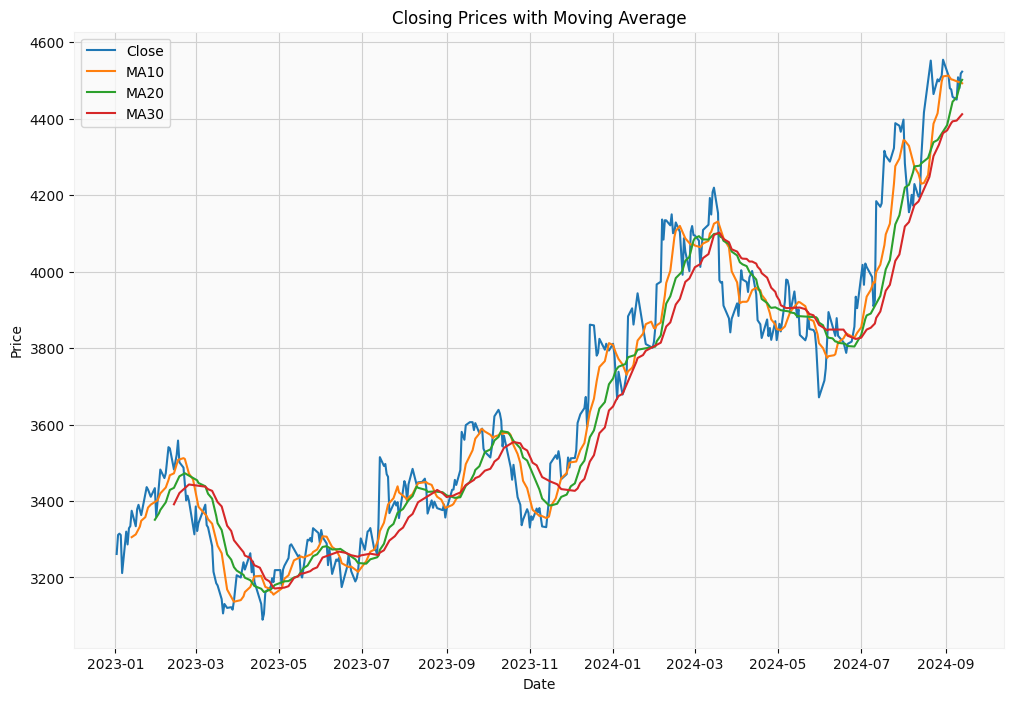

In [50]:
displayMA(data,[10,20,30])

In [64]:
#These functions are related to preprocessing the data for training
def shift_data1(df,number):
  '''shift the data point by number 'number' of days for non-LSTM and non-GRU models'''
  for i in range(1,number):
        df[f'closed_shifted_{i}'] = df['Close'].shift(-1*i)
  new_columns = [f'closed_shifted_{i}' for i in range(1, number)]
  new_columns=['Close']+new_columns
  df_new = df[new_columns]
  df_new=df_new.dropna()
  return df_new

def classification_data(df,col_name1,col_name2):
  '''This functions creates a column denoting if the price has increased or decreased on the next day and returns the df,X and y'''
  df['price_increase']=((df[col_name2]-df[col_name1])>0).astype(int)
  # df['price_increase']=df.price_increase.map({1:"increased",0:"no increase"})
  X=df.drop([col_name2,'price_increase'],axis=1).values
  y=df['price_increase'].values
  return df,X,y

def arrange_for_training(X,y):
  '''Splits data into training and test sets'''
  train_size=int(len(X)*0.8)
  X_train = X[:train_size]
  y_train = y[:train_size]
  X_test = X[train_size:]
  y_test = y[train_size:]
  return X_train,y_train,X_test,y_test

In [98]:
def train_gb(X_train,y_train):
  '''Trains a gradient boosting model for classification'''
  model = GradientBoostingClassifier(n_estimators=300, random_state=42)
  model.fit(X_train,y_train)
  return model

def train_rf(X_train,y_train):
  '''Trains a random forest model for classification'''
  model = RandomForestClassifier(n_estimators=300, random_state=42)
  model.fit(X_train,y_train)
  return model

def train_dt(X_train,y_train):
  '''Trains a decision tree model for classification'''
  model = DecisionTreeClassifier(random_state=42)
  model.fit(X_train,y_train)
  return model

def model_predict(model,X_test,y_test):
  """Predicts on test data and returns the required metrics"""
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred,labels=model.classes_)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  return y_pred,cm,accuracy,precision,recall,f1

def vizualize_results(y_test,y_pred,cm,model):
  """Vizualize the classification report and the confusion matrix"""
  print(f"The classification report is \n {classification_report(y_test, y_pred)}")
  cr=classification_report(y_test, y_pred)
  print("The confusion matrix is \n")
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
  disp.plot()

In [101]:
#number =6 implies that the prediction will be done for the 6th day, whether the price will increase or decrease that day
number=6
col1=f"closed_shifted_{number-2}"
col2=f"closed_shifted_{number-1}"

In [102]:
data_new=shift_data1(data,number)
data1,X,y=classification_data(data_new,col1,col2)
X_train,y_train,X_test,y_test=arrange_for_training(X,y)

In [103]:
#closed_shifted_5 corresponds to the day we want to predict if the price has increased or didnot increase, for this we are using the values from
#the columns Close, closed_shifted_1, closed_shifted_2, closed_shifted_3, closed_shifted_4.So using a sequence of 5 values, we are predicting for the 6tyh value
data_new

,Close,closed_shifted_1,closed_shifted_2,closed_shifted_3,closed_shifted_4,closed_shifted_5,price_increase
Date,,,,,,,
2023-01-02,3261.449951,3311.350098,3314.649902,3311.100098,3211.550049,3319.949951,1
2023-01-03,3311.350098,3314.649902,3311.100098,3211.550049,3319.949951,3286.399902,0
2023-01-04,3314.649902,3311.100098,3211.550049,3319.949951,3286.399902,3328.699951,1
2023-01-05,3311.100098,3211.550049,3319.949951,3286.399902,3328.699951,3334.350098,1
2023-01-06,3211.550049,3319.949951,3286.399902,3328.699951,3334.350098,3374.550049,1
...,...,...,...,...,...,...,...
2024-09-02,4521.049805,4512.350098,4479.250000,4475.950195,4456.750000,4449.549805,0
2024-09-03,4512.350098,4479.250000,4475.950195,4456.750000,4449.549805,4507.850098,1
2024-09-04,4479.250000,4475.950195,4456.750000,4449.549805,4507.850098,4479.350098,0


In [104]:
function_mappings={"Gradient Boost":train_gb,"Random Forest":train_rf,"Decision Tree":train_dt}

For the model Gradient Boost the classification report and the confusion matrix are as follows 

The classification report is 
               precision    recall  f1-score   support

           0       0.52      0.38      0.43        40
           1       0.54      0.67      0.60        43

    accuracy                           0.53        83
   macro avg       0.53      0.52      0.52        83
weighted avg       0.53      0.53      0.52        83

The confusion matrix is 

For the model Random Forest the classification report and the confusion matrix are as follows 

The classification report is 
               precision    recall  f1-score   support

           0       0.47      0.68      0.56        40
           1       0.50      0.30      0.38        43

    accuracy                           0.48        83
   macro avg       0.49      0.49      0.47        83
weighted avg       0.49      0.48      0.46        83

The confusion matrix is 

For the model Decision Tree the classif

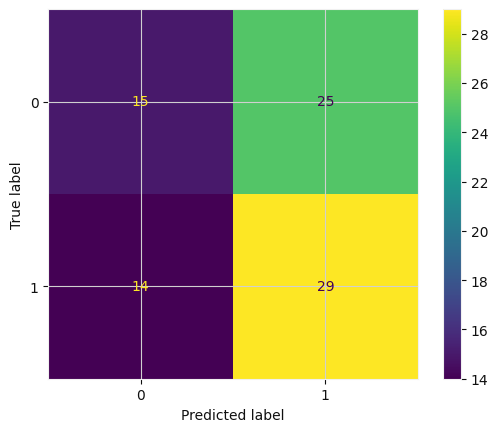

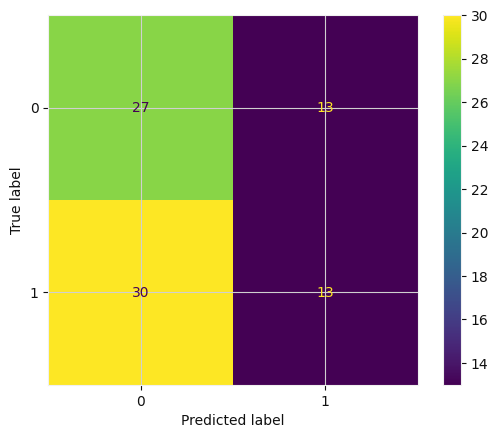

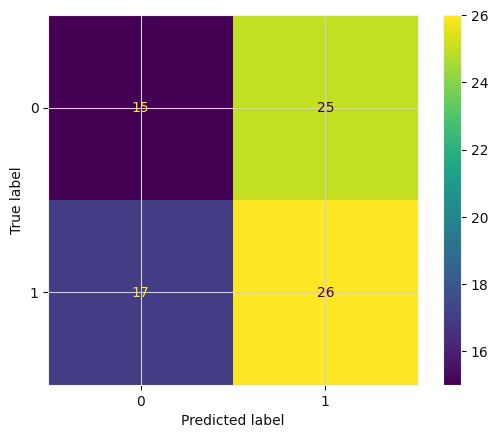

In [105]:
#checking results by varying sequence length and the models together
results=[]
for model_name,model_function in function_mappings.items():
  result=dict()
  model=model_function(X_train,y_train)
  y_pred,cm,accuracy,precision,recall,f1=model_predict(model,X_test,y_test)
  print(f"For the model {model_name} the classification report and the confusion matrix are as follows \n")
  vizualize_results(y_test,y_pred,cm,model)
  result['number']=number
  result['model']=model_name
  result['accuracy']=round(accuracy*100,2)
  result['precision']=round(precision*100,2)
  result['recall']=round(recall*100,2)
  result['f1']=round(f1*100,2)
  results.append(result)

In [106]:
result_dataframe=pd.DataFrame(results)
result_dataframe

,number,model,accuracy,precision,recall,f1
0,6,Gradient Boost,53.01,53.70,67.44,59.79
1,6,Random Forest,48.19,50.00,30.23,37.68
2,6,Decision Tree,49.40,50.98,60.47,55.32


#Checking with sequence length



























In [107]:
sequence_length=[5,6,7,8,9,10,11,12,13,14,15]

For the sequence length 5 and model Gradient Boost the classification report and the confusion matrix are as follows 

The classification report is 
               precision    recall  f1-score   support

           0       0.56      0.45      0.50        40
           1       0.57      0.67      0.62        43

    accuracy                           0.57        83
   macro avg       0.57      0.56      0.56        83
weighted avg       0.57      0.57      0.56        83

The confusion matrix is 

For the sequence length 5 and model Random Forest the classification report and the confusion matrix are as follows 

The classification report is 
               precision    recall  f1-score   support

           0       0.48      0.70      0.57        40
           1       0.52      0.30      0.38        43

    accuracy                           0.49        83
   macro avg       0.50      0.50      0.48        83
weighted avg       0.50      0.49      0.47        83

The confusion matrix 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


For the sequence length 12 and model Gradient Boost the classification report and the confusion matrix are as follows 

The classification report is 
               precision    recall  f1-score   support

           0       0.44      0.60      0.51        40
           1       0.43      0.29      0.34        42

    accuracy                           0.44        82
   macro avg       0.44      0.44      0.43        82
weighted avg       0.44      0.44      0.42        82

The confusion matrix is 

For the sequence length 12 and model Random Forest the classification report and the confusion matrix are as follows 

The classification report is 
               precision    recall  f1-score   support

           0       0.51      0.78      0.61        40
           1       0.57      0.29      0.38        42

    accuracy                           0.52        82
   macro avg       0.54      0.53      0.50        82
weighted avg       0.54      0.52      0.49        82

The confusion matri

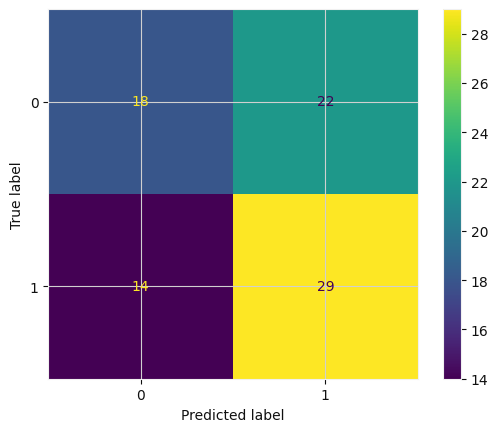

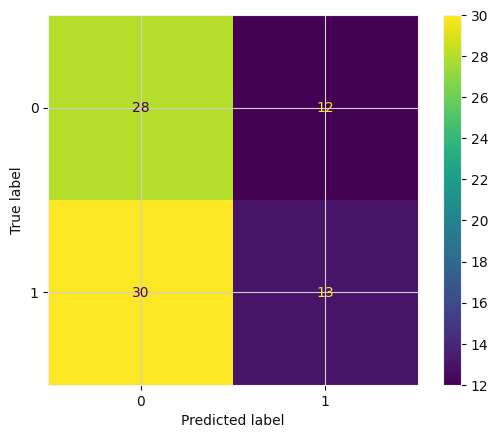

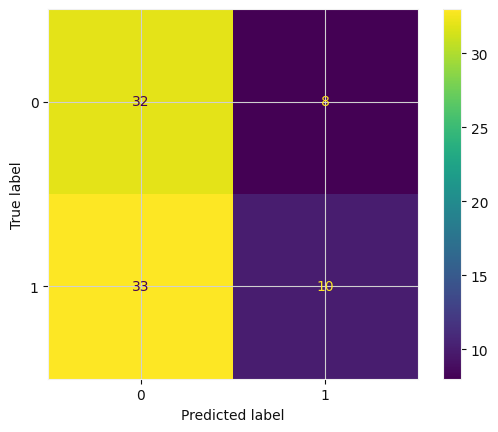

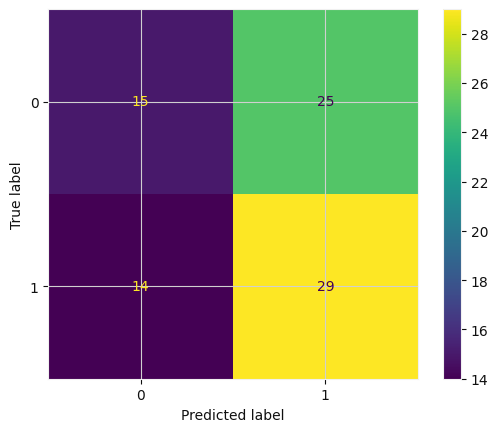

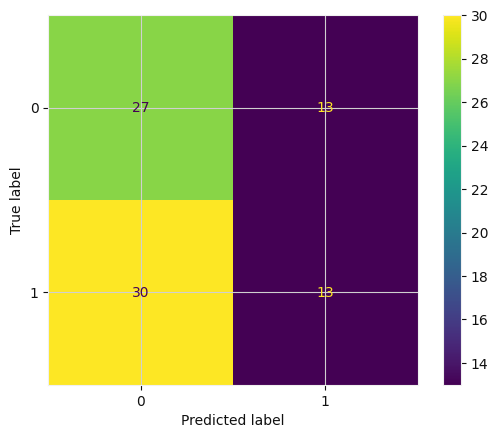

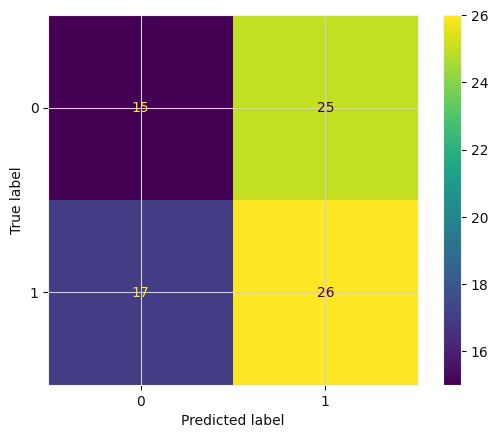

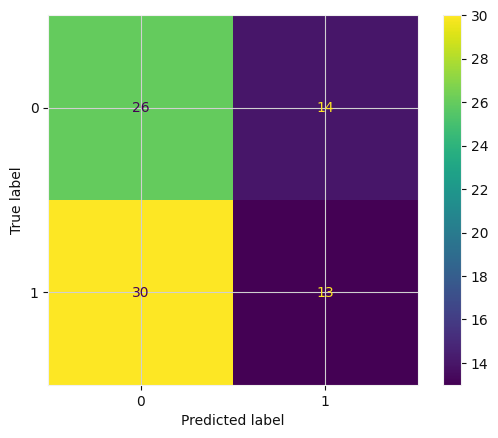

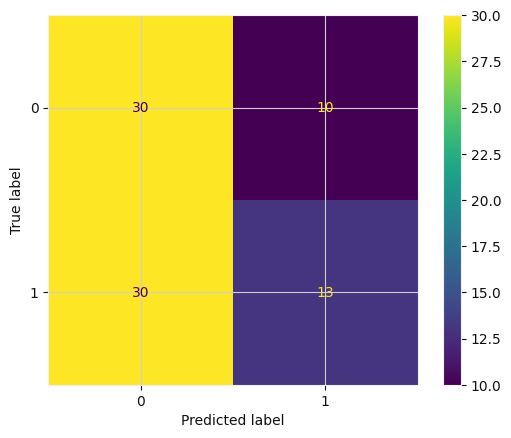

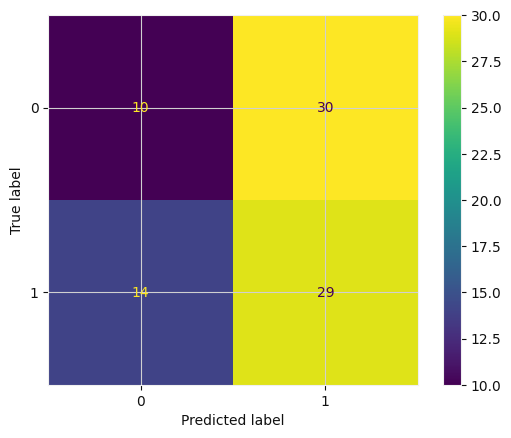

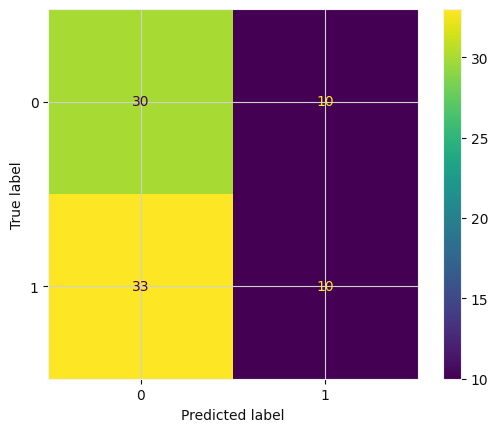

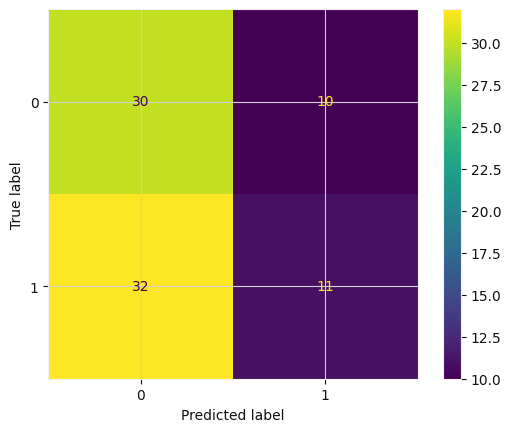

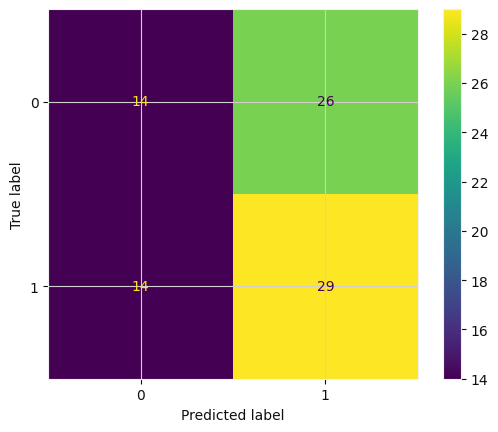

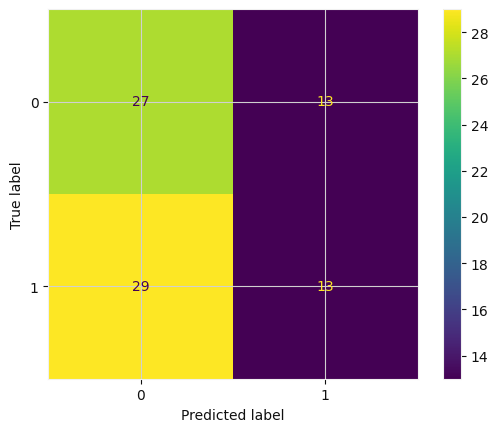

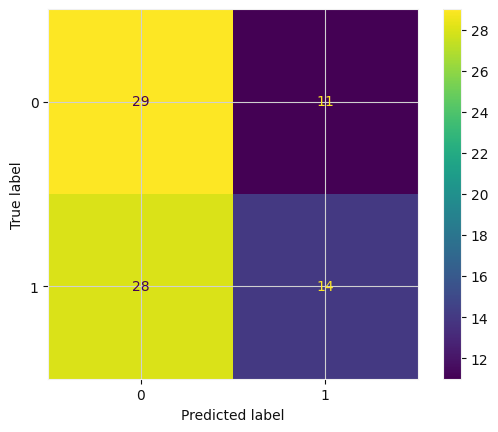

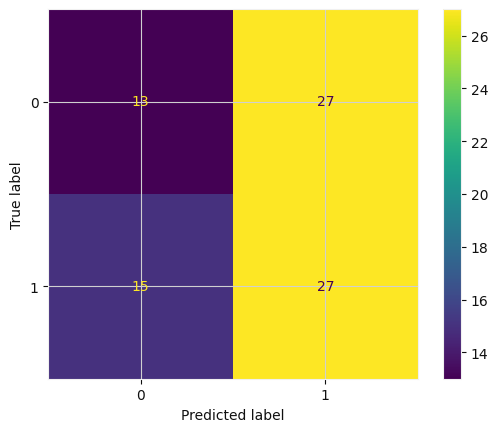

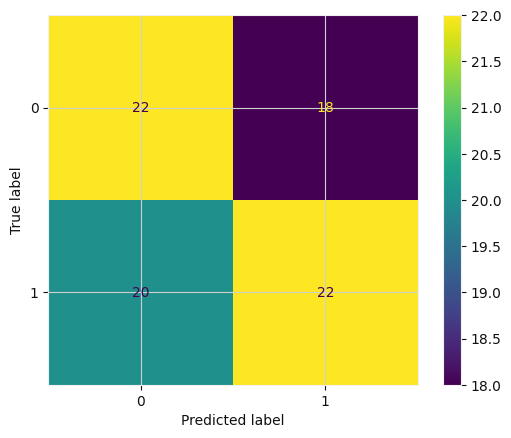

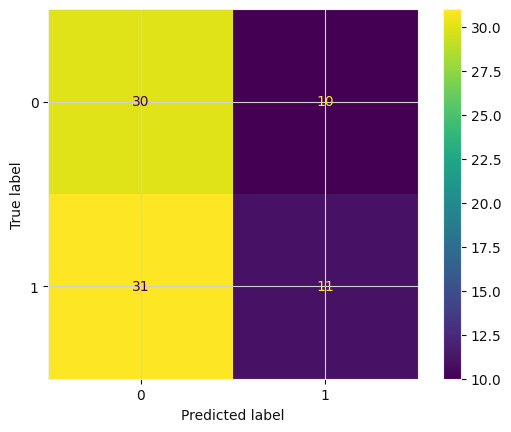

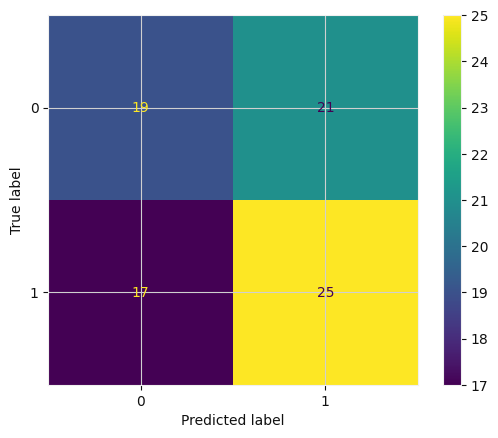

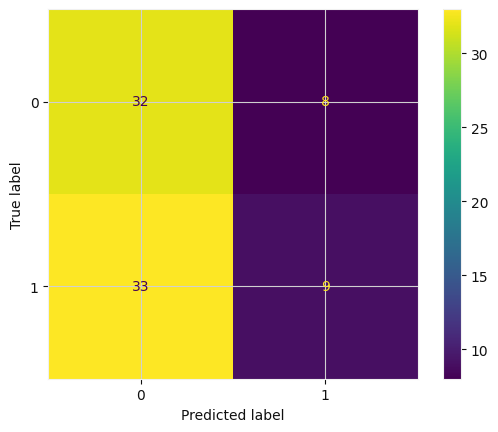

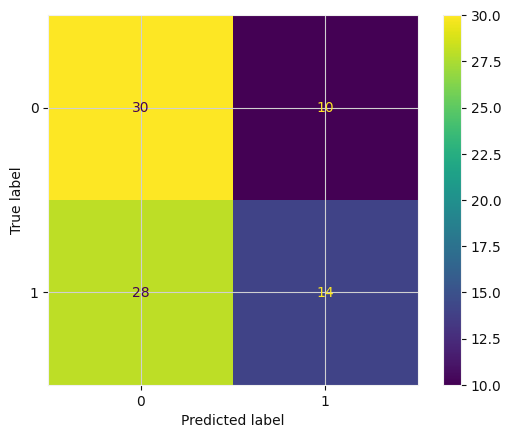

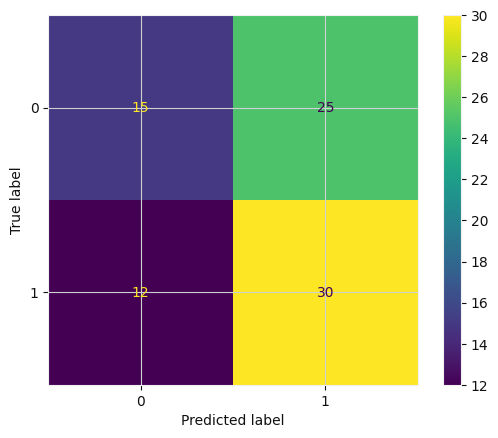

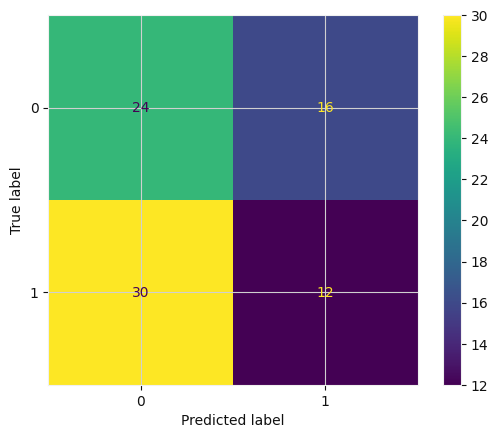

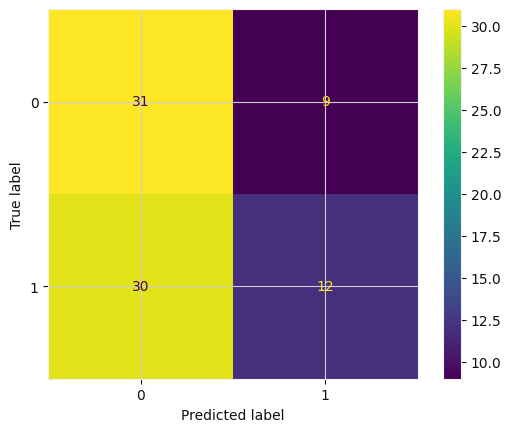

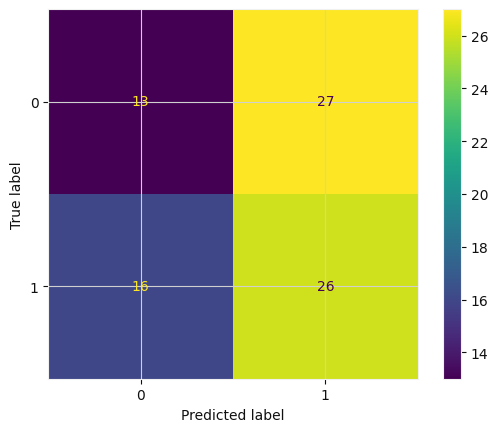

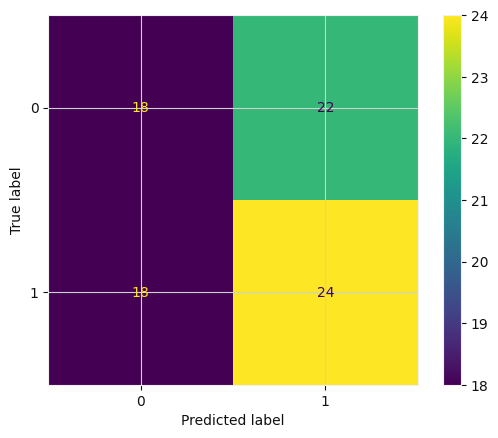

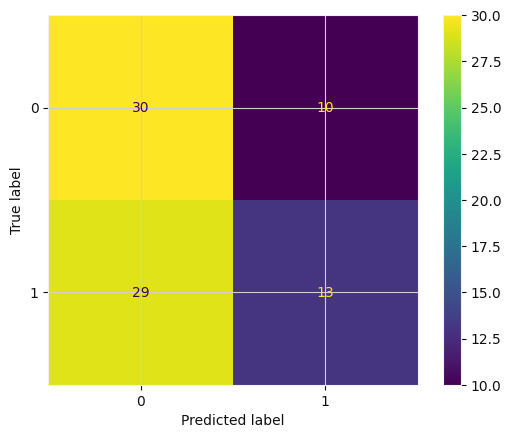

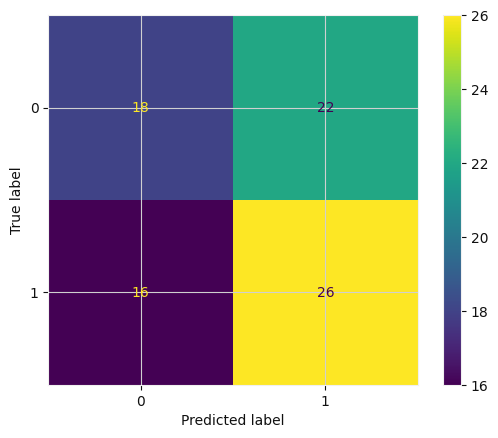

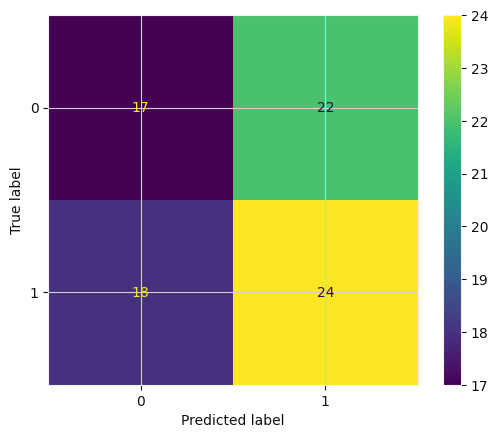

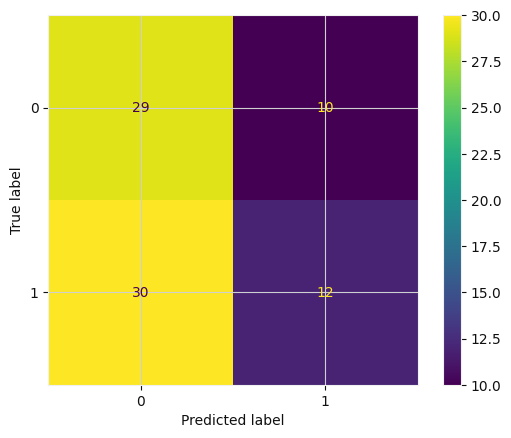

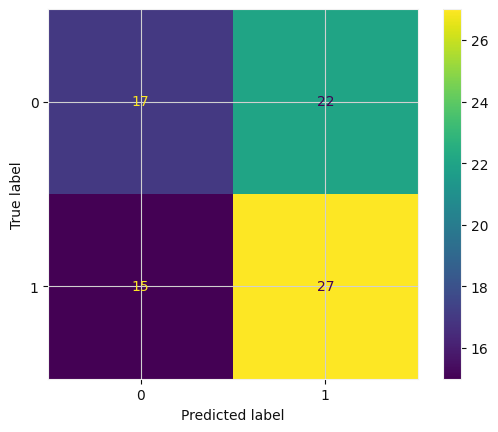

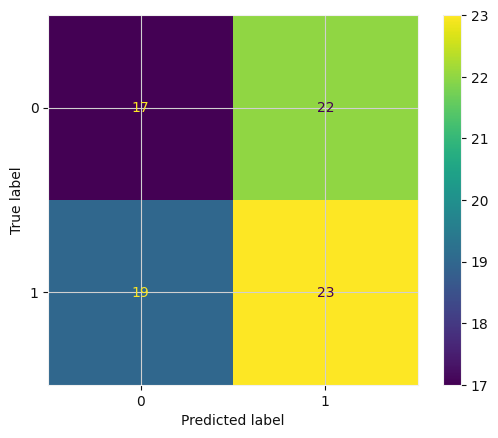

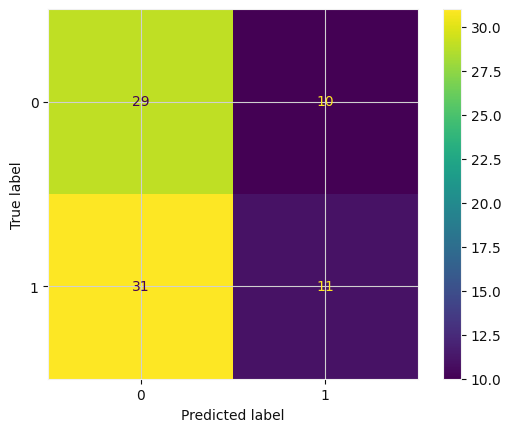

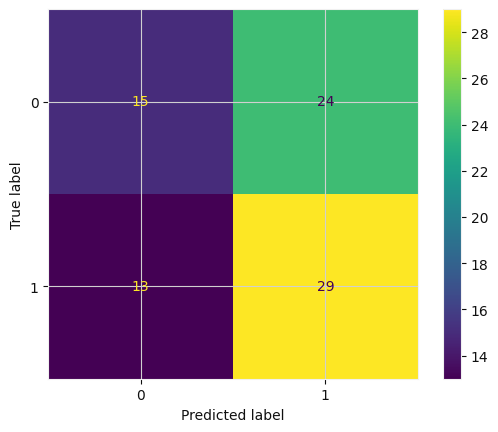

In [110]:
results=[]
for number in sequence_length:
  col1=f"closed_shifted_{number-2}"
  col2=f"closed_shifted_{number-1}"
  data_new=shift_data1(data,number)
  data1,X,y=classification_data(data_new,col1,col2)
  X_train,y_train,X_test,y_test=arrange_for_training(X,y)

  for model_name,model_function in function_mappings.items():
    result=dict()
    model=model_function(X_train,y_train)
    y_pred,cm,accuracy,precision,recall,f1=model_predict(model,X_test,y_test)
    print(f"For the sequence length {number} and model {model_name} the classification report and the confusion matrix are as follows \n")
    vizualize_results(y_test,y_pred,cm,model)
    result['sequence_length']=number
    result['model']=model_name
    result['accuracy']=accuracy*100
    result['precision']=precision*100
    result['recall']=recall*100
    result['f1']=f1*100
    results.append(result)

In [111]:
result_dataframe=pd.DataFrame(results)
result_dataframe

,sequence_length,model,accuracy,precision,recall,f1
0,5,Gradient Boost,56.626506,56.862745,67.441860,61.702128
1,5,Random Forest,49.397590,52.000000,30.232558,38.235294
2,5,Decision Tree,50.602410,55.555556,23.255814,32.786885
3,6,Gradient Boost,53.012048,53.703704,67.441860,59.793814
4,6,Random Forest,48.192771,50.000000,30.232558,37.681159
5,6,Decision Tree,49.397590,50.980392,60.465116,55.319149
6,7,Gradient Boost,46.987952,48.148148,30.232558,37.142857
7,7,Random Forest,51.807229,56.521739,30.232558,39.393939
8,7,Decision Tree,46.987952,49.152542,67.441860,56.862745
9,8,Gradient Boost,48.192771,50.000000,23.255814,31.746032


In [115]:
model_names=result_dataframe.model.unique()

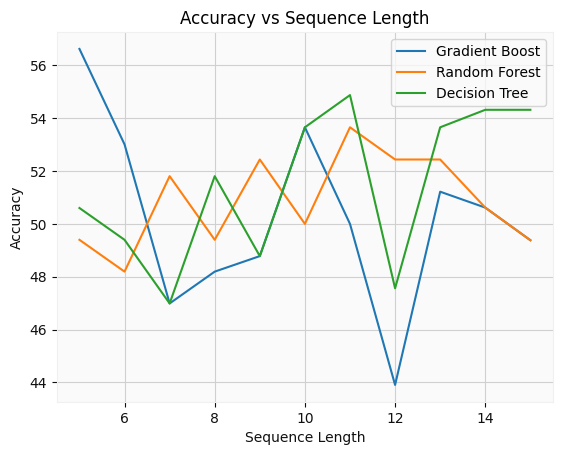

In [116]:
#plotting accuracy
for model_name in model_names:
  model_result=result_dataframe[result_dataframe.model==model_name]
  plt.plot(model_result.sequence_length,model_result.accuracy,label=model_name)
plt.legend()
plt.xlabel("Sequence Length")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Sequence Length")
plt.show()

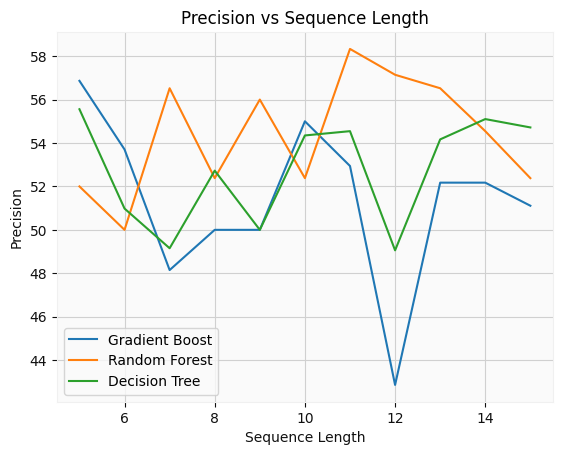

In [117]:
#plotting precision
for model_name in model_names:
  model_result=result_dataframe[result_dataframe.model==model_name]
  plt.plot(model_result.sequence_length,model_result.precision,label=model_name)
plt.legend()
plt.xlabel("Sequence Length")
plt.ylabel("Precision")
plt.title("Precision vs Sequence Length")
plt.show()

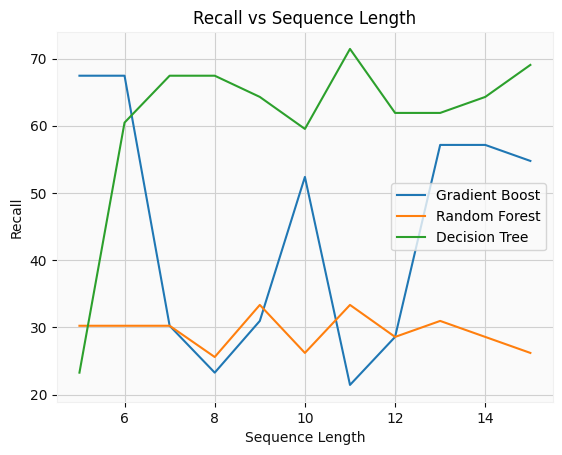

In [118]:
#plotting recall
for model_name in model_names:
  model_result=result_dataframe[result_dataframe.model==model_name]
  plt.plot(model_result.sequence_length,model_result.recall,label=model_name)
plt.legend()
plt.xlabel("Sequence Length")
plt.ylabel("Recall")
plt.title("Recall vs Sequence Length")
plt.show()